# ANEOS FORSTERITE MODEL: STRENGTH PARAMETERS NOTEBOOK

## ANEOS FORSTERITE<br>RELEASE VERSION: SLVTv1.0G1 <br>RELEASE DATE: 20191005

This Jupyter notebook provides documentation for a new ANEOS forsterite model EOS. This notebook is a companion to the following paper that presents modifications to the ANEOS code and new forsterite model:

<b>Stewart, S., et al. (revised). The shock physics of giant impacts:  Key requirements for the equations of state. In J. Lane, T. Germann, and M. Armstrong (Eds.), 21st Biennial APS Conference on Shock Compression of Condensed Matter (SCCM19). AIP Publishing. (https://arxiv.org/abs/1910.04687)</b><p>

When this model EOS is used, cite this paper and the doi-tagged Zenodo archive that corresponds to the release version of the forsterite EOS model. The README file in the github repository provides the history of release versions and doi numbers.
 
Future updates to this forsterite EOS will be archived in Zenodo doi-tagged version-controlled releases.

This notebook also highlights several technical issues that arise in developing and implementing EOS models into hydrocodes. We introduce two tabulated quality parameters to help guide usage of this EOS model.<p>

Sarah T. Stewart <br>
sts@ucdavis.edu <br>
October 5, 2019<br>
Documentation updated October 10, 2019<br>
April 12, 2023: strength parameters notebook added<p>

<b>VERSION INFORMATION</b><br>
Forsterite EOS Version: Forsterite-ANEOS-SLVTv1.0G1<br>
SLVT# translates to solid-liquid-vapor-thermal model adjustment-version number<br>
G1 = the gridded EOS tables used the gridflag=1 definition for the grid points<br>
SLVTv1.0G1 Release Date: 10/05/2019<br>
GitHub: https://github.com/ststewart/aneos-forsterite-2019/<p>




In [1]:
from datetime import datetime
presentime = datetime.now()
print("Current date and time:", presentime)

# Record the verions information for these calculation for posterity
import platform
print('python version (orig 3.9.12): ',platform.python_version())
del platform
import matplotlib
print('matplotlib version (orig 3.5.1): ', matplotlib.__version__)
del matplotlib
import numpy
print('numpy version (orig 1.21.5): ', numpy.__version__)
del numpy
import scipy
print('scipy version (orig 1.7.3): ', scipy.__version__)
del scipy
import pandas
print('pandas version (orig 1.4.2): ', pandas.__version__)
del pandas

# this prevents some error messages for inline plotting in a jupyter notebook
%matplotlib inline 
# import python libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
import numpy as np
from scipy import interpolate
import colormaps as local_cmaps
import subprocess
import pandas as pd
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
#
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["patch.force_edgecolor"] = True
#
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', alpha=0.5):

    # Loop over data points; create box from errors at each point
    errorboxes = [Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
                  for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(xdata, ydata, xerr=xerror, yerr=yerror,
                          fmt='None', ecolor='k')

    return artists


# define index function (must be a more efficient way to do this...)
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
#
# LOAD EXTERNAL FUNCTIONS AND OBJECT CLASSES
# defines rational function interpolation functions rf1d and rf2d
#%run rfinterpolation.py 
# defines class objects for extEOStable and functions to read in ANEOS input and output
# READ THIS CODE IF YOU WANT TO UNDERSTAND THE FILE STRUCTURES
%run eostable.py 
# Run the following help for the functions in the class
#help(extEOStable())


from scipy.optimize import curve_fit


Current date and time: 2023-04-12 20:43:30.511527
python version (orig 3.9.12):  3.9.16
matplotlib version (orig 3.5.1):  3.7.0
numpy version (orig 1.21.5):  1.24.2
scipy version (orig 1.7.3):  1.10.0
pandas version (orig 1.4.2):  1.4.2


In [2]:
# -------------------------------------------------------------
# USER INPUTS
#-------------------------------------------------------------
# NOTEBOOK MODE
#-------------------------------------------------------------
#
DEVMODE = 0 # 1=development mode; 0=release mode
#
#-------------------------------------------------------------
# OPTIONS TO REMOVE TENSION REGION AND CONSTRUCT A GADGET2 TABLE
#-------------------------------------------------------------
#
REMOVETENSIONFLAG=1  # 0- keep tension region; 1- remove tension region
MAKEGADGETTABLE=1  # 1=make table; 0=do not make gadget2 table
#
#-------------------------------------------------------------
# USER MUST SET THESE VALUES TO DEFINE THE TABULATED EOS GRIDS
#-------------------------------------------------------------
#
# ====>>>>>> YOU NEED TO MAKE SURE THESE VALUES MATCH ANEOS.INPUT  <<<<=====
MODELNAME = 'Forsterite-ANEOS-SLVTv1.0G1'
# Header information must all be compatible with float format
MATID = 1.0        # MATID number
DATE = 190802.     # Date as a single 6-digit number YYMMDD
VERSION = 0.1      # ANEOS Parameters Version number
FMN = 70.          # Formula weight in atomic numbers for Mg2SiO4
FMW = 140.691      # Formula molecular weight (g/cm3) for Mg2SiO4
# The following define the default initial state for material in the 201 table
R0REF   = 3.22     # g/cm3 *** R0REF is inserted into the density array
K0REF   = 1.1E12   # dynes/cm2
T0REF   = 298.     # K -- *** T0REF is inserted into the temperature array
P0REF   = 1.E6     # dynes/cm2 -- this defines the principal Hugoniot calculated below
#


## Load ANEOS model

Model table files should already be generated with the forsterite_aneos.ipynb notebook


In [3]:
# READ IN NEW ANEOS MODEL and fill the extEOStable class object
# source in eostable.py
#------------------------------------------------------------------
NewEOS  = extEOStable() # FIRST make new empty EOS object
NewEOS.loadextsesame('NEW-SESAME-EXT.TXT') # LOAD THE EXTENDED 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.loadstdsesame('NEW-SESAME-STD.TXT') # LOAD THE STANDARD 301 SESAME FILE GENERATED BY STSM VERSION OF ANEOS
NewEOS.MODELNAME = MODELNAME # string set above in user input
NewEOS.MDQ = np.zeros((NewEOS.NT,NewEOS.ND)) # makes the empty MDQ array
#print(NewEOS.units) # these are the default units for SESAME rho-T tables
#'Units: g/cm3, K, GPa, MJ/kg, MJ/kg, MJ/K/kg, cm/s, MJ/K/kg, KPA flag. 2D arrays are (NT,ND).'

# Add the header info to the table. This could be done during the loading. 
# if made from this notebook, these values are set in the user-input above.
# ** MAKE SURE THEY MATCH ANEOS.INPUT **
NewEOS.MATID   = MATID
NewEOS.DATE    = DATE
NewEOS.VERSION = VERSION
NewEOS.FMN     = FMN
NewEOS.FMW     = FMW
NewEOS.R0REF   = R0REF
NewEOS.K0REF   = K0REF
NewEOS.T0REF   = T0REF
NewEOS.P0REF   = P0REF
#
# Load the information from ANEOS.INPUT and ANEOS.OUTPUT
NewEOS.loadaneos(aneosinfname='ANEOS.INPUT',aneosoutfname='ANEOS.OUTPUT')
#
# calculate the principal Hugoniot from the table
if DEVMODE:
    # calculate the Hugoniot and write to a file. This is from the ANEOS REFERENCE STATE
    NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF,writefilename='NEW-SESAME-HUG.TXT')
    # calculate the Hugoniot and write to a file Rowan 1993 liquid MORB initial state
    NewEOS.calcOffEOSHugoniot(r0=2.66,t0=1673.,p0=1.e-4,e0=2.2,r1=2.7,writefilename='NEW-SESAME-HUG-LIQUID.TXT')
else:
    # just calculate the Hugoniot and put it in the EOS object
    NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF)
#
# calculate the 1-bar profile; loop over temp
NewEOS.onebar.T = np.zeros(NewEOS.NT)
NewEOS.onebar.S = np.zeros(NewEOS.NT)
NewEOS.onebar.rho = np.zeros(NewEOS.NT)
it0 = np.where(NewEOS.T >= NewEOS.T0REF)[0]
id0 = np.arange(NewEOS.ND)#np.where(NewEOS.rho >= 0.8*NewEOS.R0REF)[0]
for iit in range(0,NewEOS.NT):
    NewEOS.onebar.T[iit] = NewEOS.T[iit]
    NewEOS.onebar.S[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.S[iit,id0])
    NewEOS.onebar.rho[iit] = np.interp(1.E-4,NewEOS.P[iit,id0],NewEOS.rho[id0])
    #print(iit,NewEOS.onebar.rho[iit],NewEOS.onebar.T[iit],NewEOS.onebar.S[iit]*1.E3)


Done loading ANEOS files.
ANEOS WAS CALLED WITH THE FOLLOWING INPUT, LOADED FROM FILE  ANEOS.INPUT
 *         EOS#      string for EOS name           .....Hugoniot initial........ long
 *                                                 T(eV)           Rho(g/cc)     flag
 * Reference solid Hugoniot at STP initial density and temperature
 ANEOS1    -1        'Forsterite STS SLVTv1.0'     THUG=0.02568    RHUG=3.22     LONG

 *
 *         nelem     type      rho0      temp0(K)  press0    B0/-Cbulk Gamma0    Tdebye(K)
 *         V01       V02       V03       V04       V05       V06       V07       V08
 ANEOS2    3         4         3.22      298.      1.e6      1.10E12   0.65      -1300.

 *         TG model  Gamma     Esep      Tmelt(K)  ..Critical Pt..     Thermal Conduction
 *         or S1     3*C24     erg/g     or -Em    C53       C54       H0        C41
 *         V09       V10       V11       V12       V13       V14       V15       V16
 ANEOS3    -1        7.5       1.70E11   2163. 

In [4]:
## Load literature data

## Melt curve Simon-Glatzel fit



LINEAR FITS ARE POOR FOR U(P):
solidus fit U(P GPa) MJ/kg =  [0.04316496 3.85926259]
liquidus fit U(P GPa) MJ/kg =  [0.04413969 4.81521329]
Simon-Glatzel fit is better U(P):
liquidus
Actual Ul at P=0 is  3.8636999999942145  Using 3.8637 MJ/kg
Simons fit parameters to liquidus (Uref (MJ/kg), a (GPa), c [-]; pref=0)=  3.8637 42.92162410246565 1.2871201782101036
solidus
Actual Us at P=0 is  2.863699999987672  Using 2.8637 MJ/kg
Simons fit parameters to solidus (Uref (MJ/kg), a (GPa), c [-]; pref=0)=  2.8637 31.988099104941284 1.2685303905015624
Simon-Glatzel equation to melt curve T(P):
Actual T at P=0 is  2162.9999999873385  Using 2163 K.
Simons fit parameters (tref (K), a (GPa), c [-]; pref=0)=  2163.0 8.845566763741424 3.9532674649551875


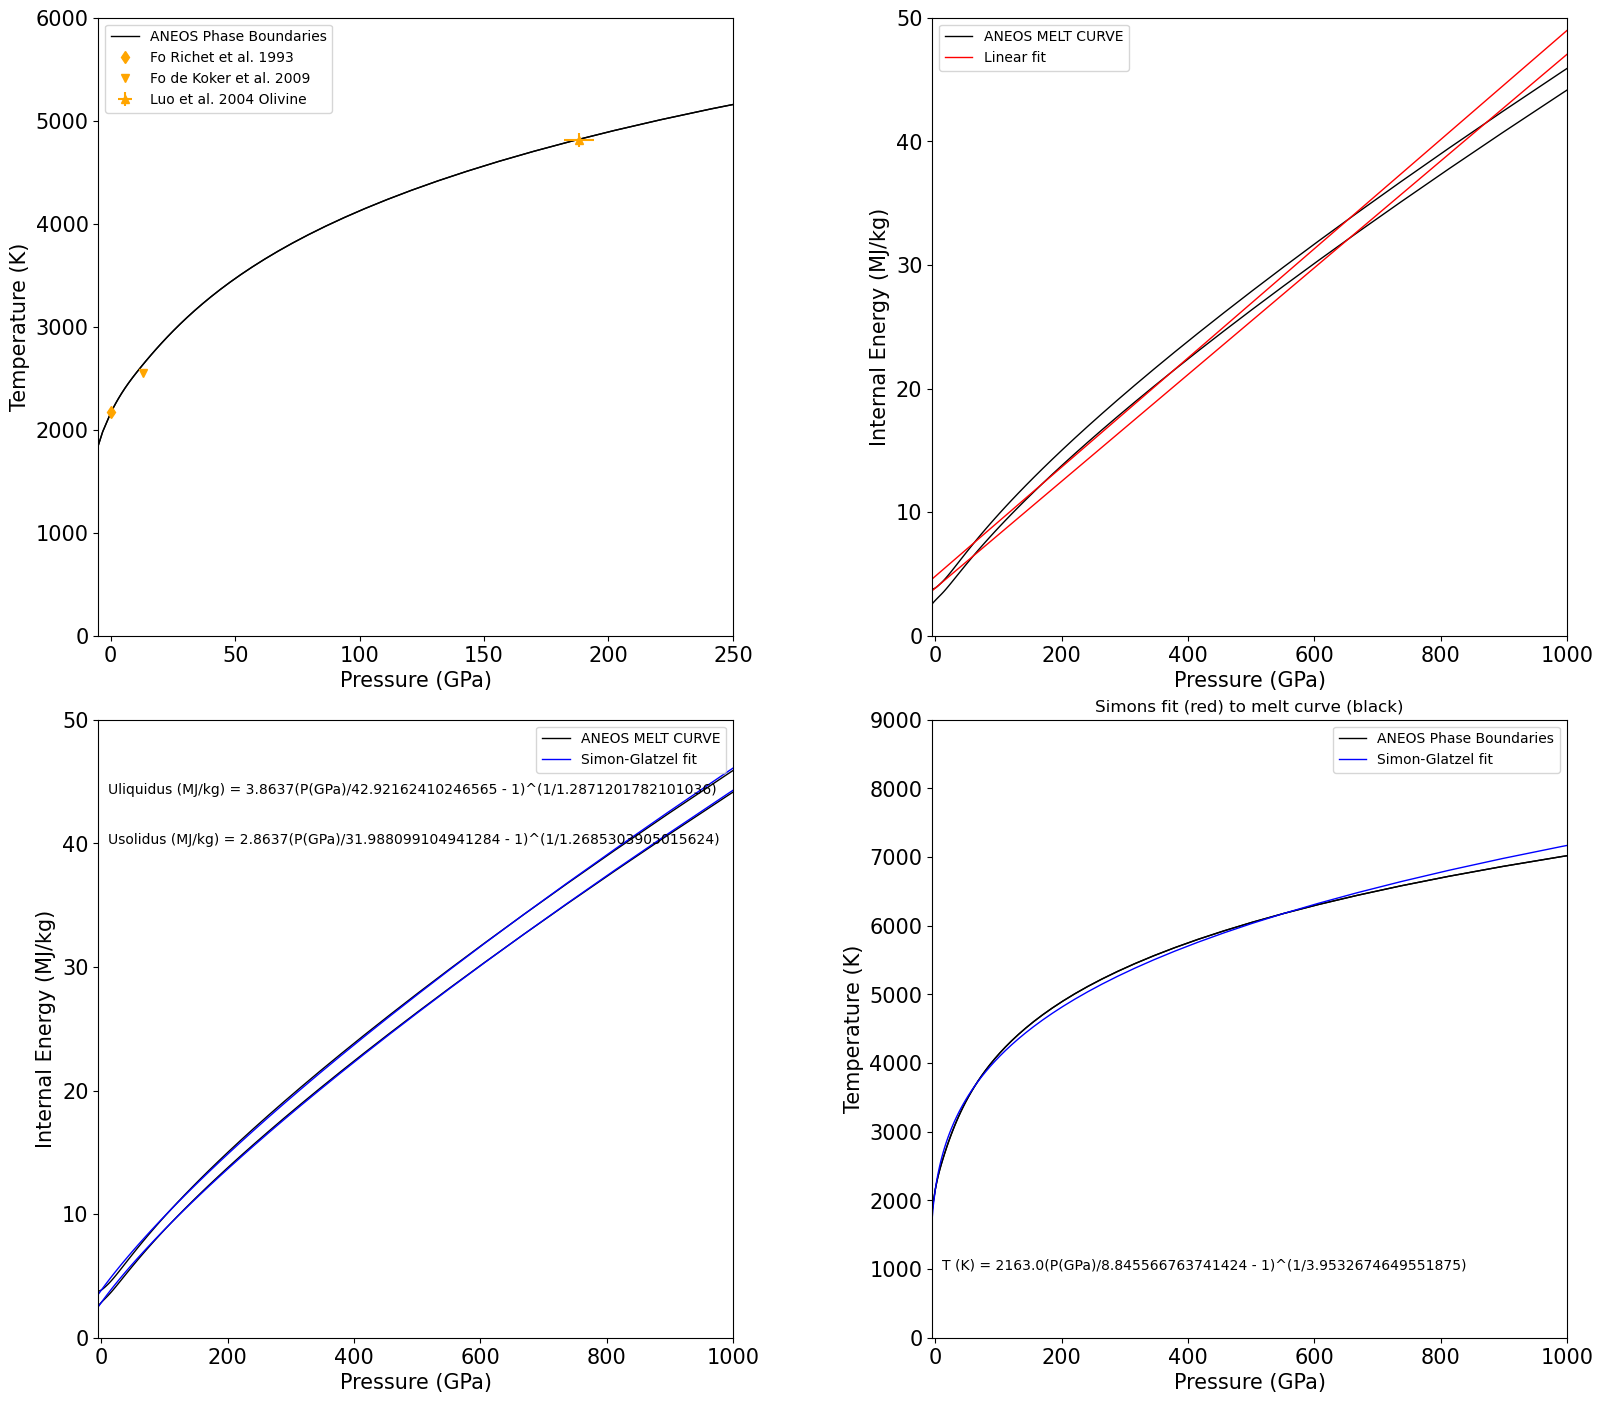

In [5]:
#========== PLOTTING STYLES FOR LOTS OF PLOTS =================

styleanhug = ['-','red',1,'ANEOS THUG,RHUG Hugoniot (liquid MORB)'] 
stylestphug = ['-','blue',1,'Tabulated STP Hugoniot']
styleanphase = ['-','black',1,'ANEOS Phase Boundaries']
stylephasept = ['o','black',6]


# PHASE DIAGRAM PLOTS
#======================LOTS OF PLOTS============================
# Plot aneos phase boundaries with focus on the vapor curve
sfont = 15
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,14))
plt.subplots_adjust(wspace=0.4)

#------------------------------



#-------
# temperature - pressure
ai=0
aj=0
if NewEOS.tp.T > 0:
    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label=styleanphase[3])
    axes[ai,aj].plot(NewEOS.mc.Ps,NewEOS.mc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2])

#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,stylestphug[0],linewidth=stylestphug[2],color=stylestphug[1],label=stylestphug[3])
#axes[ai,aj].plot(NewEOS.hug.P[0],NewEOS.hug.T[0],'o',color=stylestphug[1])

# ANEOS LIQUID HUGONIOT
# Calculate the model Hugoniot with the same initial state as Thomas & Asimow 2013
#NewEOS.calchugoniot(r0=fo_hug_liqThomas13.rho0,t0=fo_hug_liqThomas13.T0)
#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,styleliqhug[0],linewidth=styleliqhug[2],color=styleliqhug[1],label=styleliqhug[3])
# Put the STP hugoniot back into the structure
#NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF)

axes[ai,aj].set_ylabel('Temperature (K)',size=sfont)
axes[ai,aj].set_xlabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)
axes[ai,aj].set_ylim(0,6000)
axes[ai,aj].set_xlim(-5,250)

#-------
# energy - pressure
ai=0
aj=1
if NewEOS.tp.T > 0:
#    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.Ul,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label=styleanphase[3])
    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.Ul,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label='ANEOS MELT CURVE')
    axes[ai,aj].plot(NewEOS.mc.Ps,NewEOS.mc.Us,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2])

#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.U,stylestphug[0],linewidth=stylestphug[2],color=stylestphug[1],label=stylestphug[3])
#axes[ai,aj].plot(NewEOS.hug.P[0],NewEOS.hug.U[0],'o',color=stylestphug[1])

# ANEOS LIQUID HUGONIOT
# Calculate the model Hugoniot with the same initial state as Thomas & Asimow 2013
#NewEOS.calchugoniot(r0=fo_hug_liqThomas13.rho0,t0=fo_hug_liqThomas13.T0)
#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,styleliqhug[0],linewidth=styleliqhug[2],color=styleliqhug[1],label=styleliqhug[3])
# Put the STP hugoniot back into the structure
#NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF)

axes[ai,aj].set_ylabel('Internal Energy (MJ/kg)',size=sfont)
axes[ai,aj].set_xlabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)
axes[ai,aj].set_ylim(0,50)
axes[ai,aj].set_xlim(-5,1000)

print('LINEAR FITS ARE POOR FOR U(P):')
# linear fit to solidus and liquidus between 0 to 1000 GPa
zzz = np.where((NewEOS.mc.Pl > 0.) & (NewEOS.mc.Pl < 1000))[0]

res = np.polyfit(NewEOS.mc.Ps[zzz],NewEOS.mc.Us[zzz],1)
print('solidus fit U(P GPa) MJ/kg = ',res)
axes[ai,aj].plot(NewEOS.mc.Ps,res[1]+res[0]*NewEOS.mc.Ps,styleanphase[0],color='red',linewidth=styleanphase[2],label='Linear fit')

res = np.polyfit(NewEOS.mc.Pl[zzz],NewEOS.mc.Ul[zzz],1)
print('liquidus fit U(P GPa) MJ/kg = ',res)
axes[ai,aj].plot(NewEOS.mc.Pl,res[1]+res[0]*NewEOS.mc.Pl,styleanphase[0],color='red',linewidth=styleanphase[2])

#-------
# energy - pressure
ai=1
aj=0
if NewEOS.tp.T > 0:
#    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.Ul,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label=styleanphase[3])
    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.Ul,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label='ANEOS MELT CURVE')
    axes[ai,aj].plot(NewEOS.mc.Ps,NewEOS.mc.Us,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2])

#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.U,stylestphug[0],linewidth=stylestphug[2],color=stylestphug[1],label=stylestphug[3])
#axes[ai,aj].plot(NewEOS.hug.P[0],NewEOS.hug.U[0],'o',color=stylestphug[1])

# ANEOS LIQUID HUGONIOT
# Calculate the model Hugoniot with the same initial state as Thomas & Asimow 2013
#NewEOS.calchugoniot(r0=fo_hug_liqThomas13.rho0,t0=fo_hug_liqThomas13.T0)
#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,styleliqhug[0],linewidth=styleliqhug[2],color=styleliqhug[1],label=styleliqhug[3])
# Put the STP hugoniot back into the structure
#NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF)

axes[ai,aj].set_ylabel('Internal Energy (MJ/kg)',size=sfont)
axes[ai,aj].set_xlabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)
axes[ai,aj].set_ylim(0,50)
axes[ai,aj].set_xlim(-5,1000)

# Simon-Glatzel fit is better
print('Simon-Glatzel fit is better U(P):')
print('liquidus')
eref = np.interp(0,NewEOS.mc.Pl,NewEOS.mc.Ul)
print('Actual Ul at P=0 is ',eref,' Using 3.8637 MJ/kg')
eref = 3.8637
def simonsE_func(p, a, c):
    return 3.8637*np.power( (p/a + 1),(1/c) )
# only positive numbers and in a reasonable pressure range for this EOS
zzz = np.where((NewEOS.mc.Pl > 0.) & (NewEOS.mc.Pl < 1000))[0]
popt, pcov = curve_fit(simonsE_func, NewEOS.mc.Pl[zzz], NewEOS.mc.Ul[zzz])
# popt contains the optimized values of a and c
a, c = popt
print('Simons fit parameters to liquidus (Uref (MJ/kg), a (GPa), c [-]; pref=0)= ',eref, a,c)
# plot the Simon's fit
axes[ai,aj].plot(NewEOS.mc.Pl,simonsE_func(NewEOS.mc.Pl, a, c),styleanphase[0],color='blue',linewidth=styleanphase[2],label='Simon-Glatzel fit')
axes[ai,aj].text(10,44,'Uliquidus (MJ/kg) = '+str(eref)+'(P(GPa)/'+str(a)+' - 1)^(1/'+str(c)+')')

print('solidus')
eref = np.interp(0,NewEOS.mc.Ps,NewEOS.mc.Us)
print('Actual Us at P=0 is ',eref,' Using 2.8637 MJ/kg')
eref = 2.8637
def simonsE_func(p, a, c):
    return 2.8637*np.power( (p/a + 1),(1/c) )
# only positive numbers and in a reasonable pressure range for this EOS
zzz = np.where((NewEOS.mc.Ps > 0.) & (NewEOS.mc.Ps < 1000))[0]
popt, pcov = curve_fit(simonsE_func, NewEOS.mc.Ps[zzz], NewEOS.mc.Us[zzz])
# popt contains the optimized values of a and c
a, c = popt
print('Simons fit parameters to solidus (Uref (MJ/kg), a (GPa), c [-]; pref=0)= ',eref, a,c)
# plot the Simon's fit
axes[ai,aj].plot(NewEOS.mc.Ps,simonsE_func(NewEOS.mc.Ps, a, c),styleanphase[0],color='blue',linewidth=styleanphase[2])
axes[ai,aj].text(10,40,'Usolidus (MJ/kg) = '+str(eref)+'(P(GPa)/'+str(a)+' - 1)^(1/'+str(c)+')')

#-------
# pressure - temperature melt curve
ai=1
aj=1
#axes[ai,aj].plot(NewEOS.vc.Pl,NewEOS.vc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label=styleanphase[3])
#axes[ai,aj].plot(NewEOS.vc.Pv,NewEOS.vc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2])
#axes[ai,aj].plot(NewEOS.cp.P,NewEOS.cp.T,'o',color=stylephasept[1],markersize=stylephasept[2])
if NewEOS.tp.T > 0:
    axes[ai,aj].plot(NewEOS.mc.Pl,NewEOS.mc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2],label=styleanphase[3])
    axes[ai,aj].plot(NewEOS.mc.Ps,NewEOS.mc.T,styleanphase[0],color=styleanphase[1],linewidth=styleanphase[2])

#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,stylestphug[0],linewidth=stylestphug[2],color=stylestphug[1],label=stylestphug[3])
#axes[ai,aj].plot(NewEOS.hug.P[0],NewEOS.hug.T[0],'o',color=stylestphug[1])

# ANEOS LIQUID HUGONIOT
# Calculate the model Hugoniot with the same initial state as Thomas & Asimow 2013
#NewEOS.calchugoniot(r0=fo_hug_liqThomas13.rho0,t0=fo_hug_liqThomas13.T0)
#axes[ai,aj].plot(NewEOS.hug.P,NewEOS.hug.T,styleliqhug[0],linewidth=styleliqhug[2],color=styleliqhug[1],label=styleliqhug[3])
# Put the STP hugoniot back into the structure
#NewEOS.calchugoniot(r0=NewEOS.R0REF,t0=NewEOS.T0REF)

axes[ai,aj].set_ylabel('Temperature (K)',size=sfont)
axes[ai,aj].set_xlabel('Pressure (GPa)',size=sfont)
axes[ai,aj].tick_params(labelsize=sfont)
axes[ai,aj].set_ylim(0,9000)
axes[ai,aj].set_xlim(-5,1000)
axes[ai,aj].set_title('Simons fit (red) to melt curve (black)')

print('Simon-Glatzel equation to melt curve T(P):')
# fit Simon-Glatzel equation to melt curve
# CTH implementation is Tref is at Pref = zero
# mt=Tm∗ (P( I ) / simona+PONE) ∗ ∗ (PONE/ simonc )
# Simon-Glatzel equation
# Tm = Tref * [(P-Pref)/a+1]^(1/c)

tref = np.interp(0,NewEOS.mc.Pl,NewEOS.mc.T)
print('Actual T at P=0 is ',tref,' Using 2163 K.')
tref = 2163.0
# initial guesses
a = 1.84 # GPa
c = 7.27 # dimless
def simons_func(p, a, c):
    return 2163*np.power( (p/a + 1),(1/c) )
# only positive numbers and in a reasonable pressure range for this EOS
zzz = np.where((NewEOS.mc.Pl > 0.) & (NewEOS.mc.Pl < 1000))[0]
popt, pcov = curve_fit(simons_func, NewEOS.mc.Pl[zzz], NewEOS.mc.T[zzz])
# popt contains the optimized values of a and c
a, c = popt
print('Simons fit parameters (tref (K), a (GPa), c [-]; pref=0)= ',tref, a,c)
# plot the Simon's fit
axes[ai,aj].plot(NewEOS.mc.Ps,simons_func(NewEOS.mc.Ps, a, c),styleanphase[0],color='blue',linewidth=styleanphase[2],label='Simon-Glatzel fit')
axes[ai,aj].text(10,1000,'T (K) = '+str(tref)+'(P(GPa)/'+str(a)+' - 1)^(1/'+str(c)+')')


# PLOT EXPERIMENTAL CONSTRAINTS ON THE ANEOS PHASE BOUNDARIES
PLOTDATA=1
datms = 8
if PLOTDATA:

    # temperature -- pressure [2,0]
    ai=0
    aj=0
    
    # Melt curve points
    axes[ai,aj].plot(1.e-4,2174,'d',color='orange',label='Fo Richet et al. 1993')
    axes[ai,aj].plot(13.,2550,'v',color='orange',label='Fo de Koker et al. 2009')
    # Luo et al. 2004 reanalyzed temperature point
    #5.86(15) 4810(70) 188(6)
    axes[ai,aj].errorbar([188],[4810],xerr=[6],yerr=[70],fmt='^',color='orange',label='Luo et al. 2004 Olivine')

    #axes[ai,aj].plot(fo_mc_Mosen2007.P,fo_mc_Mosen2007.T,linestyle='-',color='brown',linewidth=1,label='Forsterite Melt Curve\n(Mosenfelder et al. 2007)')
    #axes[ai,aj].plot(pdt_mc_Fiquet10.Pl,pdt_mc_Fiquet10.Tl,linestyle='-',color='orange',label='Peridotite Liquidus')
    #axes[ai,aj].plot(pdt_mc_Fiquet10.Ps,pdt_mc_Fiquet10.Ts,linestyle=':',color='orange',label='Peridotite Solidus\n(Fiquet et al. 2010)')
    #axes[ai,aj].plot(pdt_mc_Boukare15.Pl,pdt_mc_Boukare15.T,linestyle='-',color='green',label='Peridotite Frac. Melt\n(Boukare et al. 2015)')
    #axes[ai,aj].plot(pdt_mc_uerr_Boukare15.Pl,pdt_mc_uerr_Boukare15.T,linestyle=':',color='green')
    #axes[ai,aj].plot(pdt_mc_lerr_Boukare15.Pl,pdt_mc_lerr_Boukare15.T,linestyle=':',color='green')



    

# don't show a plot in lower right
#axes[3,1].axis("off")

axes[0,0].legend(fontsize=sfont-5)
axes[0,1].legend(fontsize=sfont-5)
axes[1,0].legend(fontsize=sfont-5)
axes[1,1].legend(fontsize=sfont-5)




plt.tight_layout(pad=0.6)
plt.savefig(MODELNAME+'-melt-curve-fits.pdf', format='pdf', dpi=1000,transparent=True)
#--------



## Melt curve was fit from 0 to 1000 GPa
\begin{equation}
    F=A\left(\frac{P}{a}+1\right)^{\frac{1}{c}}
\end{equation}

| Variable | T(P)   | Solidus U(P) | Liquidus U(P) |
|----------|--------|--------------|---------------|
| Units    | K, GPa | MJ/kg, GPa   | MJ/kg, GPa     |
|   A      | 2163   | 2.8637       | 3.8637 |
|   a      | 8.8456 | 31.988       | 42.922 |
|   c      | 3.9533 | 1.2685       | 1.2871 |


The covariance matrices are in the code cells above.

Double check these numbers match the expressions on the plot!


end of notebook